# Fraud Detection - ML Final Project
## CS 4563
Authors:
 - Sergey Hovhannisyan
 - Arnav Kanwal

## Dataset
Dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


In [1]:
# Add some general imported libraries here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model



In [2]:
# Reading the CSV File
df = pd.read_csv("creditcard.csv", na_values='?')
df = df.dropna()


### Preprocess data: Split into train, test, and validation sets

In [29]:
X = np.array(df.loc[:, df.columns != 'Class'])
y = np.array(df['Class'])

from collections import Counter
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Use counter to print our current test-statistics, as you can see the data is highly imbalanced
print(f"Training target statistics: {Counter(y_train_val)}")
print(f"Testing target statistics: {Counter(y_test)}")


# We use an under_sampling algorithm called NearMiss to help balance our train data
from imblearn.under_sampling import NearMiss
under_sampler = NearMiss()
X_train, y_train = under_sampler.fit_resample(X_train_val, y_train_val)
X_test, y_test = under_sampler.fit_resample(X_test, y_test)
print(f"Training target statistics after undersampling: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")



Training target statistics: Counter({0: 227447, 1: 398})
Testing target statistics: Counter({0: 56868, 1: 94})
Training target statistics after undersampling: Counter({0: 398, 1: 398})
Testing target statistics: Counter({0: 94, 1: 94})


### Applying a Logistic Regression Model
Here will try two different types of regularization and apply some feature transformations and see how well this model will perform against the data.

https://analyticsindiamag.com/using-near-miss-algorithm-for-imbalanced-datasets/

In [14]:
# Import libraries used for Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures

In [30]:
# Let's start by testing logistic regression accuracy without regularization on a variety of different feature transformations
for i in range(1, 4):
    poly = PolynomialFeatures(i)
    X_train_new = poly.fit_transform(X_train)
    X_test_new = poly.fit_transform(X_test)
    logreg = LogisticRegression(max_iter=1000, penalty='none')
    logreg.fit(X_train_new, y_train)
    y_pred = logreg.predict(X_test_new)
    print(f'Accuracy of logistic regression with no regularization and transformation X^{i}: {logreg.score(X_test_new, y_test)}')

# As we can see, our new polynomial transformation features before worse against the test data, so we will stick
# our original train data.

# The next step will be using K-fold cross validation to help us identify the best hyperparameters
# as well as see if we can get our model's performance to improve and decrease overfitting by
# adding regularization.

best_score = [0, 0, 0]
best_y_pred = None

print("--------------------")
C = [0.0001, 0.1, 1, 10, 100, 1000, 1000000]
for k in range(7):
    L2_logreg = LogisticRegressionCV(Cs=C, cv=k+3, max_iter=1000)
    L2_logreg.fit(X_train, y_train)
    y_pred = L2_logreg.predict(X_test)
    score = L2_logreg.score(X_test, y_test)
    print(f'Logistic Regression Accuracy with K^{k+3}, L2 Regularization and C={max(L2_logreg.C_)} is: {score}')

    if score > best_score[0]:
        best_score[0], best_score[1] = score, max(L2_logreg.C_)
        best_score[2] = 2
        best_y_pred = y_pred

    L1_logreg = LogisticRegressionCV(Cs=C, cv=k+3, max_iter=10000, penalty='l1', solver='liblinear')
    L1_logreg.fit(X_train, y_train)
    y_pred = L1_logreg.predict(X_test)
    score = L1_logreg.score(X_test, y_test)
    print(f'Logistic Regression Accuracy with K^{k+3}, L1 Regularization and C={max(L1_logreg.C_)} is: {score}')

    if score > best_score[0]:
        best_score[0], best_score[1] = score, max(L2_logreg.C_)
        best_score[2] = 1
        best_y_pred = y_pred

print("-------------")
print(f"Our best results were L{best_score[2]} Regularization with C={best_score[1]} and score = {best_score[0]}")

Accuracy of logistic regression with no regularization and transformation X^1: 0.8936170212765957
Accuracy of logistic regression with no regularization and transformation X^2: 0.851063829787234
Accuracy of logistic regression with no regularization and transformation X^3: 0.8457446808510638
--------------------
Logistic Regression Accuracy with K^3, L2 Regularization and C=0.1 is: 0.8723404255319149
Logistic Regression Accuracy with K^3, L1 Regularization and C=0.1 is: 0.8776595744680851
Logistic Regression Accuracy with K^4, L2 Regularization and C=1000.0 is: 0.8670212765957447
Logistic Regression Accuracy with K^4, L1 Regularization and C=1.0 is: 0.8723404255319149
Logistic Regression Accuracy with K^5, L2 Regularization and C=100.0 is: 0.8617021276595744
Logistic Regression Accuracy with K^5, L1 Regularization and C=1.0 is: 0.8723404255319149
Logistic Regression Accuracy with K^6, L2 Regularization and C=10.0 is: 0.8776595744680851
Logistic Regression Accuracy with K^6, L1 Regulari

### Let's plot a confusion matrix of our results and get an idea of prediction accuracy
https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

Text(0.5, 1.0, 'Confusion Matrix of X with Accuracy Score: 0.8829787234042553')

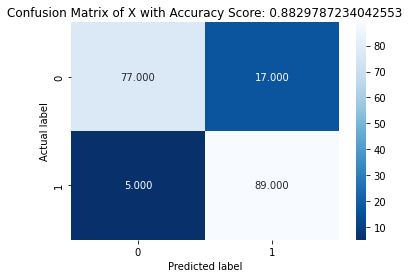

In [31]:
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, best_y_pred)
sns.heatmap(cm, annot=True, fmt=".3f", cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Confusion Matrix of X with Accuracy Score: {best_score[0]}'
plt.title(all_sample_title)

### Important Metrics for our Logistic Regression Model
We'll calculate the f-score, accuracy, prediction, and recall of our results from above.

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('Precision: %.3f' % precision_score(y_test, best_y_pred))
print('Recall: %.3f' % recall_score(y_test, best_y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, best_y_pred))
print('F1-Score: %.3f' % f1_score(y_test, best_y_pred))

Precision: 0.840
Recall: 0.947
Accuracy: 0.883
F1-Score: 0.890
